In [ ]:
# execute to import notebook styling for tables and width etc.
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen('https://raw.githubusercontent.com/DataScienceUWL/DS775v2/master/ds755.css')
HTML(response.read().decode("utf-8"));

import warnings
warnings.filterwarnings('ignore')

In [2]:
# imports
%matplotlib notebook
from scipy.optimize import minimize
import babel.numbers as numbers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd
import array
import random
import json
from deap import algorithms, base, creator, tools
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Metaheuristics, Global Optimization, and all that ...

The goal of global optimization is to find the global optimimum value which means we want to identify the best possible soluiton in the entire search space.  However for many problems the search space is too large and/or the function landscape is too complicated to guarantee that the best solution can be found.  

A metaheuristic algorithm attempts to find a good solution without any guarantee of being able to find the best solution.  Often metaheuristics are stochastic in nature, that is they incorporate randomness as an element of the search, but they aren't generally completely random in nature.  They often incorporate search patterns which are known to work well for the problem at hand.

Unfortunately there is no single algorithm which works best for all classes of problems.  This is often referred to as a "no free lunch theorem" in optimization.  We'll focus on the two stochastic optimization algorithms that are described in your textbook:  simulated annealing and genetic algorithms.  

# Simulated Annealing

In a hill-climbing local search we only allow moves that increase the objective function value.  Here is our pseudo-code from the previous lesson:

```
 set starting state 
 while local_condition 
     select a move 
     if acceptable 
         do the move 
         if new optimum 
             remember it 
 endwhile 
 ```

Simulated annealing is a trajectory based method for generating a sequence of solutions and is similar our basic "hill-climbing" local search algorithm.  In a strict hill-climbing algorithm we only allow uphill moves, but in simulated move we sometimes allow downhill moves and are more likely to allow downhill moves in the early part of the search.  The idea is that to find the tallest peak in a mountain range we have to first descend from a lower peak.

The probability of a downhill move is determined by a temperature parameter that decreases throughout the search.  The probability of a downhill move depends on the size of the downhill move compared to the temperature.  At high temperatures large and small downhill moves are probable, but as the temperature decreases only small downhill moves are probable so that the search performs similarly to a local search at low temperatures.

Here is pseudo-code for simulated annealing:
```
 set starting state and initial temperature
 while local_condition 
     select a move 
     if acceptable 
         do the move 
         if new optimum or random # < probability determined by temperature
             remember it
     decrease temperature
 endwhile 
 ```
 
Choosing the initial temperature and the manner in which the temperature decreases are critical to the performance of simulated annealing.  We'll start with a temperature schedule that looks like this:
$$ T = T_0 \alpha^n.$$
Where $T_0$ is the initial temperature, $0 < \alpha < 1,$ and $n$ is the number of iterations.   This is called geometric temperature decay, but many other choices are possible.  In the next section we'll demonstrate simulated annealing for the traveling salesman problem.

## Simulated Annealing with TSP (video)

In [ ]:
# execute this cell for video
from IPython.display import IFrame
IFrame(
    "XXX_link_XXX",
    width=640,
    height=360)

We'll use the seven city example TSP from the textbook. Find the shortest tour (or cheapest cost) to visit all 7 cities and return to the starting city in the following graph:

<img src="./images/HillierTSP.png" width=400>

We'll store all of the intercity distances in a two dimensional list that we call distance_matrix. For cities that aren't connected we'll use the "bigM" method and introduce a distance of 100 between those pairs of cities so that those routes won't be included in the tour. Note that the picture labels the cities 1 through 7, but in Python we'll use 0 through 6.  The data is stored in the included json file.


In [16]:
# load data (this may have to be adapted for different problems)
with open("data/HillierTSP.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]
individual_size = tsp["TourSize"]

# define objective function
def tour_distance(individual, dist_mat):
    distance = dist_mat[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_mat[gene1][gene2]
    return distance

def sub_tour_reversal(tour):
    # reverse a random tour segment
    i, j = np.sort(np.random.choice(individual_size, 2, replace=False))
    swapped = np.concatenate((tour[0:i], tour[j:-individual_size + i - 1:-1],
                           tour[j + 1:individual_size]))
    return [int(swapped[i]) for i in range(individual_size)]


# initialize with a random tour
current_tour = np.random.permutation(np.arange(individual_size)).tolist()
current_dist = tour_distance(current_tour, distance_matrix)
best_tour = current_tour
best_dist = current_dist
temp = 50  # choose initial temperature around the beginning tour distance
alpha = 0.99
iteration = 1
print('Starting Distance {:d} and Starting Temp {:d}'.format(current_dist,temp))

max_moves_no_improve = 100
num_moves_no_improve = 0
while (num_moves_no_improve < max_moves_no_improve):
    num_moves_no_improve += 1
    new_tour = sub_tour_reversal(current_tour)
    new_dist = tour_distance(new_tour, distance_matrix)
    delta = current_dist - new_dist
    prob = min(np.exp(np.min(delta, 0) / temp),1)
    accept = new_dist < current_dist or np.random.uniform()< prob
    if accept:
        current_tour = new_tour
        current_dist = new_dist
        if current_dist < best_dist:
            best_tour = current_tour
            best_dist = current_dist
            num_moves_no_improve = 0
    temp *= alpha
    iteration += 1
    print(new_dist,accept,best_dist,prob,temp)

Starting Distance 250 and Starting Temp 50
342 False 250 0.15881742610692068 49.5
250 True 250 1.0 49.005
339 False 250 0.162652182124138 48.51495
342 True 250 0.1501196434352683 48.0298005
249 True 249 1 47.549502495
155 True 155 1 47.07400747005
155 True 155 1.0 46.6032673953495
157 True 155 0.9579923888405768 46.137234721396005
335 False 155 0.021109011672704632 45.675862374182046
255 False 155 0.11700327416419481 45.219103750440226
245 False 155 0.14283285973390825 44.76691271293582
337 False 155 0.017938128520154903 44.31924358580646
335 False 155 0.018019261061351374 43.876051149948395
157 True 155 1.0 43.437290638448914
335 False 155 0.016608154361560695 43.002917732064425
337 False 155 0.015210603587222846 42.57288855474378
160 True 155 0.9319581376543717 42.14715966919634
341 False 155 0.013643708019343379 41.725688072504376
254 False 155 0.1051035877349439 41.308431191779334
157 True 155 1 40.89534687986154
155 True 155 1 40.48639341106293
157 True 155 0.9518009877765248 40.0

### <font color = "blue"> Self Assessment: Simulated Annealing for Gerrymandering </font>

Copy the gerrymandering code from Lesson 4 and adapt the simulated annealing code above to try to find a solution in which republicans win 9 of the 10 districts.  Beware that you're trying to maximize the fitness so you'll either need to rearrange the code above or use a negated fitness function.

## Using the `simanneal` package (video)

The `simanneal` package is pretty straightforward to use. Using the simanneal package has a couple of advantages over our version of simulated annealing above.  First, we don't have to worry about the algorithm framework.  Second, we don't have to worry about figuring out a temperature schedule.  While it's possible to specify a temperature schedule, it is far easier to use the `auto` scheduler and specify the approximate amount of time we'd like to wait for a solution

The package works by making an object of the Annealer class and then calling the anneal method on that object. To set up a problem we have to set three things in our instance of the Annealer class.

1.  the state initializer 
2.  the move function that tells the anneal how to generate new moves
3.  the fitness function (fitness is called energy in this package).

The anneal method appears to always find minima so you may have to negate your function if you want to find a maximum.

In [98]:
# execute this cell for video
from IPython.display import IFrame
IFrame(
    "XXX_link_XXX",
    width=640,
    height=360)

In [65]:
from simanneal import Annealer

class TravellingSalesmanProblem(Annealer):

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravellingSalesmanProblem, self).__init__(state)  # important!

    def move(self):
        """Reverse random segment"""
        tour = self.state
        n = len(tour)
        i, j = np.sort(np.random.choice(n, 2, replace=False))
        swapped = np.concatenate((tour[0:i], tour[j:-n + i - 1:-1],tour[j + 1:n]))
        self.state = [int(swapped[i]) for i in range(n)]
        return self.energy()
    
    def energy(self):
        dist_mat = self.distance_matrix
        tour = self.state
        distance = dist_mat[tour[-1]][tour[0]]
        for gene1, gene2 in zip(tour[0:-1], tour[1:]):
            distance += dist_mat[gene1][gene2]
        return distance


# load data (this may have to be adapted for different problems)
with open("tsp/HillierTSP.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]
init_tour = np.random.permutation(np.arange(len(distance_matrix))).tolist()

tsp = TravellingSalesmanProblem(init_tour, distance_matrix)
tsp.set_schedule(tsp.auto(minutes=.2)) #set approximate time to find results
# since our state is just a list, slice is the fastest way to copy
tsp.copy_strategy = "slice"
best_tour, best_dist = tsp.anneal()

best_dist

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.49000         63.00    14.40%     0.00%     0:00:05    -1:59:59 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.49000         63.00    16.36%     0.00%     0:00:12     0:00:00

63

### <font color = "blue"> Self Assessment: Simulated Annealing for Gerrymandering </font>

Copy the gerrymandering code from Lesson 4 and use the `simanneal` package to try to find a solution in which republicans win 9 of the 10 districts.  Beware that you're trying to maximize the fitness so you'll either need to use a negated fitness function.  You'll also have to set the cities data frame in the initializer (similar to the distance matrix in the tsp above).

## Simulated Annealing for Continuous Optimization

Simulated annealing was designed for combinatorial (discrete) optimization problems, but has been adapted to continuous optimization problems.  The main issue is how to generate a new move at each iteration.  There are many variations, but often the move is selected at random from a suitable probability distribution such as a normal or uniform distribution.

The objective functions we consider here aren't from real applications, instead they're chosen to give you an idea how the algorithm works for difficult optimization problems with many local optima.  It's good to have this sort of thing in mind when, for instance, you're trying to train a complicated neural network and have to optimize the weights in the network to find the best fit to your data.

### A non-convex 2D example

We found this two-dimensional example in <a href="http://apmonitor.com/me575/index.php/Main/SimulatedAnnealing">this tutorial</a> on simulated annealing.

Find the minimum value of 
$$f(x,y) = 0.2 + x^2 + y^2 - 0.1 \cos(6 \pi x) - 0.1 \cos(6 \pi y)$$ 

for $-1 \leq x,y \leq 1$.  This function is similar to the Rastrigin function and the global minimum value is $f(0,0) = 0$.  A contour plot, shown below, illustrates that there are several local minima.  The <a href = "http://apmonitor.com/me575/index.php/Main/SimulatedAnnealingtutorial">tutorial</a> itself is worthy of a look and has a nice flow chart outlining how simulated annealing works.

<IPython.core.display.Javascript object>


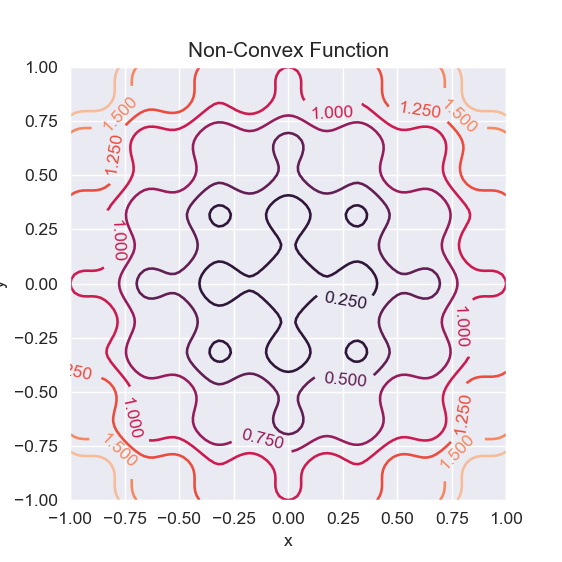

In [3]:
# define objective function and show a contour plot
def f(x):
    obj = 0.2 + sum(x**2 - 0.1*np.cos(6*np.pi*x))
    return obj

# compute on mesh for plotting
numx = 101
numy = 101
x = np.linspace(-1.0, 1.0, numx)
y = np.linspace(-1.0, 1.0, numy)
xx,yy=np.meshgrid(x,y)
z = np.zeros((numx,numy))
for i in range(numx):
    for j in range(numy):
        z[i,j] = f(np.array([xx[i,j],yy[i,j]]))

# Create a contour plot
plt.figure(figsize=(4.5,4.5))
# Plot contours
contours = plt.contour(xx,yy,z)
# Label contours
plt.clabel(contours, inline=1, fontsize=10)
# Add some text to the plot
plt.title('Non-Convex Function')
plt.xlabel('x')
plt.ylabel('y');

The simulated annealing algorithm below follows the same outline as the one we introduced above for the TSP.  The initial temperature is much lower because the range of function values we are dealing with is about 0 to 2.  We also just set the code to run for a fixed number of iterations since it is more difficult to monitor a continuous optimization for a solution that is not improving.  New moves are generated by adding values selected from a normal distribution to each coordinate.  The mean of the normal distribution is zero and the standard deviation is 2/6 or 1/3 so that 6 standard deviations fit in the bounds $[-1,1]$ on each coordinate.

In [6]:
# our homebrewed simulated annealing code for this problem

current_x = np.random.uniform(low=-1, high=1, size=2)
current_obj = f(current_x)
best_x = current_x
best_obj = current_obj
temp = 2  # choose initial temperature around the beginning tour distance
alpha = 0.99
iteration = 1
max_iterations = 1000
# save some results for plotting
trajectory = [[iteration, current_x[0], current_x[1], current_obj, best_obj]]

while (iteration < max_iterations):  # could have also used a for loop
    new_x = current_x + np.random.normal(loc=0, scale=1 / 3, size=2)
    new_x = np.minimum([1, 1], np.maximum([-1, -1], new_x))
    new_obj = f(new_x)
    delta = current_obj - new_obj
    prob = min(np.exp(np.min(delta, 0) / temp), 1)
    accept = new_obj < current_obj or np.random.uniform() < prob
    if accept:
        current_x = new_x
        current_obj = new_obj
        if current_obj < best_obj:
            best_x = current_x
            best_obj = current_obj
        trajectory.append(
            [iteration, current_x[0], current_x[1], current_obj, best_obj])
    temp *= alpha
    iteration += 1

(best_obj, best_x)

(0.009170255309633946, array([ 0.02203121, -0.00314264]))

Notice that we get close to the optimal solution, but only to within 2 to 4 decimal places.  Simulated annealing is very good at exploring the entire space of solutions but is not so efficient at converging to a nearby minimum value.  Most practical simulated annealing type search algorithms for continuous optimization combine a gradient based local search with the annealing process to promote faster convergence.

<IPython.core.display.Javascript object>


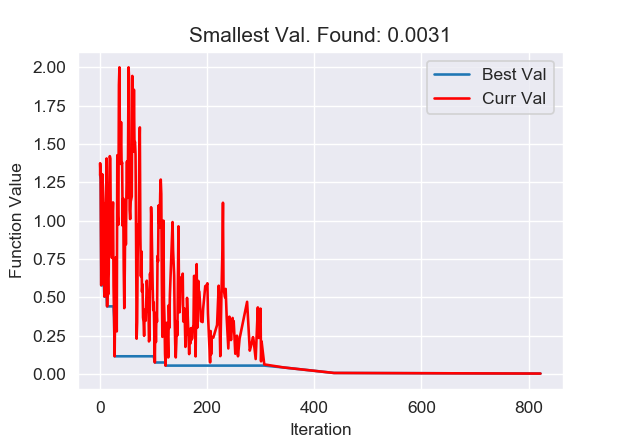

In [82]:
# plot search convergence

trajectory = np.array(trajectory)
fig = plt.figure(figsize=(5, 3.5))
line_best, = plt.plot(trajectory[:,0],trajectory[:,4],label='Best Val')
line_curr, = plt.plot(trajectory[:,0],trajectory[:,3],label='Curr Val',color='red')
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.legend(handles=[line_best, line_curr])
plt.title('Smallest Val. Found: {:0.4f}'.format(best_obj));

On the contour plot below we've overlaid the trajectory of accepted solutions.  You can see that simulated annealing does a good job of exploring the solution space, but seems to waste a lot of effort bouncing around and many of the moves are clipped at the edges.  Notice also that we are accepting a lot of uphill moves.  This may be an indication that our temperature is too large or not decreasing fast enough.  Setting a good temperature schedule and making a good choice of moves is critical to getting efficient convergence.

<IPython.core.display.Javascript object>


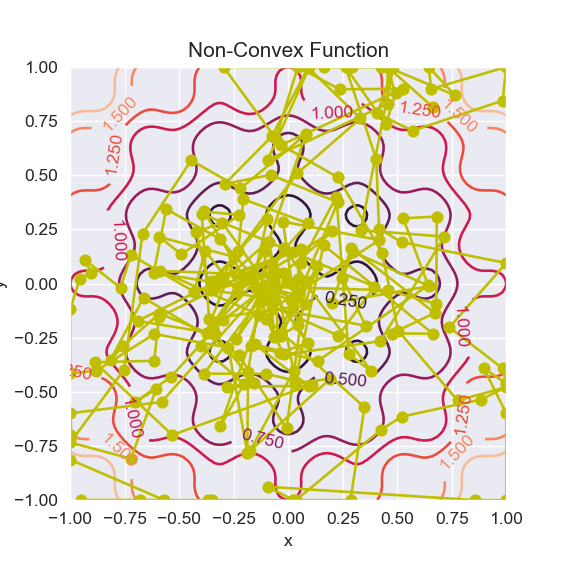

In [83]:
# Create a contour plot showing trajectory of accepted solutions
plt.figure(figsize=(4.5,4.5))
# Plot contours
contours = plt.contour(xx,yy,z)
# Label contours
plt.clabel(contours, inline=1, fontsize=10)
# add the trajectory
plt.plot(trajectory[:,1],trajectory[:,2],'y-o')
# Add some text to the plot
plt.title('Non-Convex Function')
plt.xlabel('x')
plt.ylabel('y');

#### <font color = "blue"> Self Assessment: Continuous Self Annealing </font> 

Experiment with the code above to see if you can get reliable and faster convergence to the global optimum.  Try playing with the temperature and the size of the moves (reduce the scale parameter).   There is no right answer here, rather the idea is to develop some intuition as to how simulated annealing works.

### Using the `simanneal` package

Setting up the simanneal package for continuous optimization really isn't much different than setting it up for the TSP above.  The primary difference is that new moves are selected randomly from a normal probability distribution in each coordinate.  The scale (standard deviation) of the normal distribution will affect how the algorithm converges as you'll see in the self-assessment exercise below.

In [8]:
from simanneal import Annealer

class NonConvex2D(Annealer):

    # no extra data so just initialize with state
    def __init__(self, state):
        super(NonConvex2D, self).__init__(state)  # important!

    def move(self):
        """Add a perturbation selected from normal distribution"""
        xy = self.state
        # scale = sd is selected so that 6 standard deviations fit inside bounds
        xy_new = xy + np.random.normal(loc = 0,scale =1/3,size=2)
        # clip to fit bounds
        xy_clipped = np.minimum([1,1],np.maximum([-1,-1],xy_new))
        self.state = xy_clipped
        return self.energy()
    
    def energy(self):
        x = self.state
        return 0.2 + sum( x**2 - 0.1*np.cos(6*np.pi*x))

x0 = np.random.uniform(low=-1,high=1,size=2)
problem2D = NonConvex2D( x0 )
problem2D.set_schedule(problem2D.auto(minutes=.2))
problem2D.copy_strategy = "method" # we're using np.array to hold our state variable, so we'll use .copy() to clone
best_x, best_fun = problem2D.anneal()

(best_fun,best_x)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00170          0.00     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00170          0.00     0.06%     0.02%     0:00:11     0:00:00

(5.942178186335578e-06, array([ 5.60512758e-04, -4.98617685e-05]))

#### <font color = "blue"> Self Assessment: Continuous Self Annealing with `simanneal` </font> 

Again, experiment with the code above. How does changing the scale of the moves and minutes to convergence affect the final results?

# Genetic Algorithms

You should have read about the basics of genetic algorithms in the textbook.  Genetic algorithms are a vast subject and we'll just scratch the surface.  Fortunately there seem to be tons of free tutorials and other resources available for learning more about genetic algorithms.  The pseudocode for a genetic algorithm is as follows:
```
Generate the initial population
Compute fitness
Repeat
    Selection
    Crossover
    Mutation
    Compute fitness
Until population has converged
```

Here are just a few notes about the algorithm:
* population = set of trial solutions that are also called individuals
* fitness = objective function
* selection = choosing the most promising solutions in the current population but leaving a few bad ones for diversity
* crossover = combining or breeding the selected solutions to generate new candidate solutions
* mutation = randomly tweaking some of the solutions in the current population to encourage exploration of the solution space

We'll utilize the <a href="https://github.com/deap/deap">Distributed Evolutionary Algorithms in Python (DEAP)</a> package which, at the cost of some abstraction, yields a very powerful platform for assembling genetic algorithms to solve endless types of problems.

## Genetic Algorithm for TSP - Example (video)

In the video below we'll walk through all of the elements of setting up a problem using DEAP.  We'll also look at the results of each step to get an idea of what is going on in the genetic algorithm.  In the next couple of sections we'll see a more streamlined version of a DEAP genetic algorithm that we'll use for solving problems.

In [9]:
# execute this cell for video
from IPython.display import IFrame
IFrame(
    "XXX_link_XXX",
    width=640,
    height=360)

We'll use the seven city example TSP from the textbook.  Find the shortest tour (or cheapest cost) to visit all 7 cities and return to the starting city in the following graph:

<img src="./images/HillierTSP.png" width = 400>

We'll store all of the intercity distances in a two dimensional list that we call `distance_matrix`.  For cities that aren't connected we'll use the "bigM" method and introduce a distance of 100 between those pairs of cities so that those routes won't be included in the tour. *Note that the picture labels the cities 1 through 7, but in Python we'll use 0 through 6.*

In [13]:
# load problem data
with open("data/HillierTSP.json", "r") as tsp_data:
    tsp = json.load(tsp_data)

distance_matrix = tsp["DistanceMatrix"]
ind_size = tsp["TourSize"] # number fo variables or dimension of the problem

pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6
0,0,12,10,100,100,100,12
1,12,0,8,12,100,100,100
2,10,8,0,11,3,100,9
3,100,12,11,0,11,10,100
4,100,100,3,11,0,6,7
5,100,100,100,10,6,0,9
6,12,100,9,100,7,9,0


In [14]:
def tour_distance(individual, dist_mat):
    # an individual is a tour 
    distance = dist_mat[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_mat[gene1][gene2]
    return distance    

def tour_distance_tuple(individual, dist_mat):
    return (tour_distance(individual, dist_mat),)

optimal_tour = [0,1,3,5,6,4,2]
tour_distance_tuple(optimal_tour, distance_matrix)

(63,)

In [17]:
# create a minimization problem
creator.create("HillierTSP", base.Fitness, weights=(-1.0, ))
# tells us what kind of individuals we'll have - arrays of integers
creator.create("Individual",list,fitness=creator.HillierTSP)

toolbox = base.Toolbox()

# define how we create an individual and a population
def create_individual(ind_size):
    return random.sample(range(ind_size),ind_size) # choose a random permutation of 0 .... ind_size-1
toolbox.register("indices",create_individual,ind_size)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# fitness function with extra argument distance_matrix
toolbox.register("evaluate", tour_distance_tuple, dist_mat = distance_matrix)

# Selection
toolbox.register("select", tools.selTournament, tournsize=3)
# Crossover
toolbox.register("mate", tools.cxPartialyMatched) # could also use cxOrdered
# Mutation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)

cx_prob = 0.7
mut_prob = 0.2
pop_size = 10
pop = toolbox.population(n = pop_size)
# show the population
pop

[[6, 3, 1, 2, 0, 4, 5],
 [2, 4, 3, 5, 6, 1, 0],
 [6, 1, 4, 3, 5, 0, 2],
 [4, 5, 6, 1, 2, 3, 0],
 [4, 5, 1, 6, 3, 0, 2],
 [6, 2, 0, 3, 1, 5, 4],
 [0, 6, 2, 1, 3, 5, 4],
 [6, 3, 2, 0, 4, 5, 1],
 [3, 2, 6, 5, 4, 0, 1],
 [4, 6, 2, 5, 0, 1, 3]]

In [18]:
# Evaluate the entire population
fitnesses = map(toolbox.evaluate, pop)
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# show the fitness values    
[ind.fitness.values[0] for ind in pop]

[245.0, 155.0, 340.0, 334.0, 419.0, 244.0, 157.0, 427.0, 159.0, 251.0]

In [19]:
# Select the next generation individuals
selected = toolbox.select(pop, len(pop))
# Clone the selected individuals
offspring = list(map(toolbox.clone,selected))
# show selected offspring
offspring

[[4, 6, 2, 5, 0, 1, 3],
 [0, 6, 2, 1, 3, 5, 4],
 [6, 2, 0, 3, 1, 5, 4],
 [2, 4, 3, 5, 6, 1, 0],
 [2, 4, 3, 5, 6, 1, 0],
 [6, 2, 0, 3, 1, 5, 4],
 [2, 4, 3, 5, 6, 1, 0],
 [3, 2, 6, 5, 4, 0, 1],
 [3, 2, 6, 5, 4, 0, 1],
 [2, 4, 3, 5, 6, 1, 0]]

In [20]:
[ind.fitness.values[0] for ind in offspring]

[251.0, 157.0, 244.0, 155.0, 155.0, 244.0, 155.0, 159.0, 159.0, 155.0]

In [21]:
# Apply crossover and mutation on the offspring
for child1, child2 in zip(offspring[::2], offspring[1::2]):
    if random.random() < cx_prob:
        toolbox.mate(child1, child2)
        del child1.fitness.values
        del child2.fitness.values
offspring

[[4, 6, 2, 5, 0, 1, 3],
 [0, 6, 2, 1, 3, 5, 4],
 [2, 4, 3, 0, 1, 5, 6],
 [4, 6, 0, 5, 2, 1, 3],
 [2, 4, 3, 5, 6, 1, 0],
 [6, 2, 0, 3, 1, 5, 4],
 [2, 4, 6, 5, 3, 1, 0],
 [6, 2, 3, 5, 4, 0, 1],
 [3, 2, 6, 5, 4, 0, 1],
 [2, 4, 3, 5, 6, 1, 0]]

In [22]:
for mutant in offspring:
    if random.random() < mut_prob:
        toolbox.mutate(mutant)
        del mutant.fitness.values
offspring

[[4, 3, 2, 5, 6, 1, 0],
 [0, 6, 2, 1, 3, 5, 4],
 [2, 4, 3, 0, 1, 5, 6],
 [4, 6, 0, 5, 2, 1, 3],
 [2, 4, 3, 5, 6, 1, 0],
 [6, 2, 0, 3, 1, 5, 4],
 [2, 4, 6, 1, 3, 5, 0],
 [0, 2, 6, 5, 3, 4, 1],
 [3, 2, 6, 5, 4, 0, 1],
 [2, 4, 3, 5, 6, 1, 0]]

In [23]:
# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
fitnesses = map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

# The population is entirely replaced by the offspring
pop[:] = offspring

## Define a GA function

The DEAP function comes with a few standard algorithms, but they're pretty simple.  For instance the standard evolution algorithm runs for a fixed number of generations.  Following the <a href="https://deap.readthedocs.io/en/master/">documentation for DEAP</a> we assemble our own genetic algorithm that stops after no improvement has been made for a certain number of generations.  Essentially we're combining all of the elements discussed in the previous section into a function that we can call for each problem.

After defining the problem, we can experiment with the adjustable parameters by just calling the function using different values:
* pop_size = how many individuals in the population, larger means more exploration, but at with more fitness evaluations and slower convergence
* cx_prob = crossover probability that two a pair of selected individuals breed and create new offspring.
* mut_prob = mutation probability that an individual will be mutated
* max_gen = maximum number of iterations for the genetic algorithm
* max_no_improve = algorithm will stop early if no improvement is made for this many generations

In [24]:
def customGA(pop_size, cx_prob, mut_prob, max_gen, max_no_improve):

    pop = toolbox.population(n=pop_size)
    logbook = tools.Logbook()
    hof = tools.HallOfFame(1)

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    hof.update(pop)
    best_val = hof[0].fitness.values
    num_no_improve = 0
    generation = 0

    while num_no_improve < max_no_improve and generation < max_gen:

        # Select the next generation individuals
        selected = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, selected))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_prob:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mut_prob:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        num_evals = 0
        for ind, fit in zip(invalid_ind, fitnesses):
            num_evals += 1
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # track the best value and reset counter if there is a change
        hof.update(pop)
        curr_best_val = hof[0].fitness.values[0]
        num_no_improve += 1
        if curr_best_val != best_val:
            best_val = curr_best_val
            num_no_improve = 0

        # record stats
        record = stats.compile(pop)
        logbook.record(gen=generation, evals=num_evals, **record)

        # increment generation
        generation += 1

    best_x = list(hof[0])

    return best_val, best_x, logbook

## Solve the Hillier TSP Problem (video)

Run the code below to find a good solution to the textbook TSP problem.  You may have to run it more than once to find the optimal tour length of 63.  The plot at the end shows both the best distance found and the average distance of the tours in each generation.  The algorithm stops if there has been no change in the optimal distance over 40 generations.  In the video below we explain the overall code and highlight the places you'd have to make changes to use DEAP for different problems.

In [ ]:
# execute this cell for video
from IPython.display import IFrame
IFrame(
    "XXX_link_XXX",
    width=640,
    height=360)

<IPython.core.display.Javascript object>


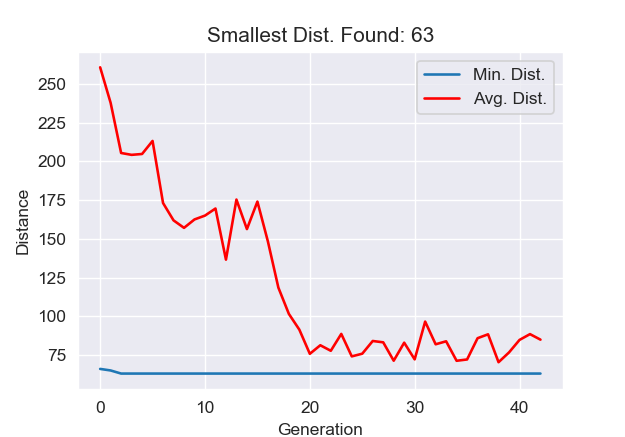

In [29]:
# imports
import array
import random
import json
from deap import algorithms, base, creator, tools
import numpy as np

# load data (this may have to be adapted for different problems)
with open("tsp/HillierTSP.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]
individual_size = tsp["TourSize"]

# define objective function
def tour_distance(individual, dist_mat):
    # an individual is a tour 
    distance = dist_mat[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_mat[gene1][gene2]
    return distance    

def tour_distance_tuple(individual, dist_mat):
    return (tour_distance(individual, dist_mat),)

# create a minimization problem
creator.create("FitnessTSP", base.Fitness, weights=(-1.0, ))
# tells us what kind of individuals we'll have - arrays of integers

creator.create("Individual",
               array.array,
               typecode='i',
               fitness=creator.FitnessTSP)

# configure toolbox
toolbox = base.Toolbox()
# define how we create an individual and a poopulation
def create_individual(ind_size):
    return random.sample(range(ind_size),ind_size) # choose a random permutation of 0 .... ind_size-1
toolbox.register("indices",create_individual,ind_size)

toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# set the fitness function
# notice we are registering the distance matrix from above as an extra argument
toolbox.register("evaluate", tour_distance_tuple, dist_mat=distance_matrix)

# Selection
toolbox.register("select", tools.selTournament, tournsize=3)
# Crossover
toolbox.register("mate", tools.cxPartialyMatched)
# Mutation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)

# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# define search parameters
pop_size = 100
crossover_prob = 0.7
mutation_prob = 0.2
max_gen = 200
max_no_improve = 40

# get solution
best_dist, best_tour, log = customGA(pop_size, crossover_prob, mutation_prob,
                                     max_gen, max_no_improve)

# plot search convergence
fig = plt.figure(figsize=(5, 3.5))
line_min, = plt.plot(log.select('gen'), log.select('min'), label='Min. Dist.')
line_avg, = plt.plot(log.select('gen'),
                     log.select('avg'),
                     color='red',
                     label='Avg. Dist.')
#line_max, = plt.plot(log.select('gen'),log.select('max'),color='green',label='Max. Val.')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.legend(handles=[line_min, line_avg])
plt.title('Smallest Dist. Found: {:d}'.format(int(best_dist)));

## <font color = "blue"> Self Assessment: Gerrymandering Problem with GA </font>

Use DEAP to build a genetic algorithm to solve the gerrymandering problem from Lesson 4.

You'll need to change a few things compared to the TSP setup.  

Change 1: when you create the problem you'll need to change the weights to (1.0,) for maximization instead of minimization.

Change 2: Instead of a sequence or tour of cities, the individuals are lists of 18 integers each between 1 and 10 that assign each of the 18 cities to one of 10 districts.  You can use this code to create the individuals:

```
def create_individual(nd,nc):
    return random.choices(range(nd),k=nc)
toolbox.register("indices",create_individual,num_districts,individual_size)
```

where individual_size is really the same as num_cities.

Change 3:  experiment with tournsize in the selection operator.  Larger tournament sizes make weak individuals less likely to be selected.

Change 4: change the crossover operator to cxOnePoint (<a href="https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)">brief explanation here</a>)

Change 5: change the <a href="https://en.wikipedia.org/wiki/Mutation_(genetic_algorithm)">mutation operator</a> to randomly change individual elements to assign them to other districts like this
```
toolbox.register("mutate", tools.mutUniformInt, low = 0, up=num_districts-1, indpb=0.05)
```

Now run the algorithm and try to find a solution in which the republicans win 8 or 9 districts.  The code for the fitness function is in the cell below.  Notice that fitness_district now returns a tuple as needed by DEAP.  If you want to make a plot showing convergence you'll have to select 'max' instead of 'min' from the log.

In [94]:
# load the data + random assignment
num_districts = 10
min_voters_in_district = 150
max_voters_in_district = 350
num_cities = 18

dems = [152,81,75,34,62,38,48,74,98,66,83,86,72,28,112,45,93,72]
reps = [62,59,83,52,87,87,69,49,62,72,75,82,83,53,98,82,68,98]
cities = pd.DataFrame( data = {'dems':dems, 'reps':reps})

def summarize_districts(assign, cities):
    reps = np.zeros(num_districts, dtype=np.int32)
    dems = np.zeros(num_districts, dtype=np.int32)
    df = cities.groupby(assign).sum()
    reps[df.index] = df['reps']
    dems[df.index] = df['dems']
    total = reps + dems
    delta = np.minimum(np.maximum(total, min_voters_in_district),
                       max_voters_in_district) - total
    rep_win = reps > dems
    dict = {
        'reps': reps,
        'dems': dems,
        'total': total,
        'rep_win': rep_win
    }
    return (pd.DataFrame(data=dict))

def fitness_districts(assign, cities):
    df = cities.groupby(assign).sum()
    fitness = sum( df['reps'] > df['dems'] )
    total_voters = np.zeros(num_districts,dtype=np.int32)
    total_voters[df.index] = df.sum(axis=1)
    fitness-= np.abs(np.minimum(np.maximum(total_voters,150),350)-total_voters).sum()
    return (fitness,) # we return a tuple with the fitness

## GA for Continous Optimization (video)

We'll demonstrate using the same 2D function that we used for simulated annealing.

Find the minimum value of 
$$f(x,y) = 0.2 + x^2 + y^2 - 0.1 \cos(6 \pi x) - 0.1 \cos(6 \pi y)$$ 

for $-1 \leq x,y \leq 1$.  This function is similar to the Rastrigin function and the global minimum value is $f(0,0) = 0$.

Since the individuals in the population are now lists of real numbers, each between -1 and 1, we'll need to use a different mutation operator.  Guassian mutation is a popular one and is just the same as using the normal distribution to generate new moves in simulated annealing as generated above.  For each number (gene) in the list we randomly decide if it will be mutated (with probability `indpb`) and if so, then a normally distributed random number is added.  The crossover operator we'll use is the same one point crossover used in the gerrymandering problem above.

The video below highlights a few things about applying DEAP for continuous optimization.

In [ ]:
# execute this cell for video
from IPython.display import IFrame
IFrame(
    "XXX_link_XXX",
    width=640,
    height=360)

<IPython.core.display.Javascript object>


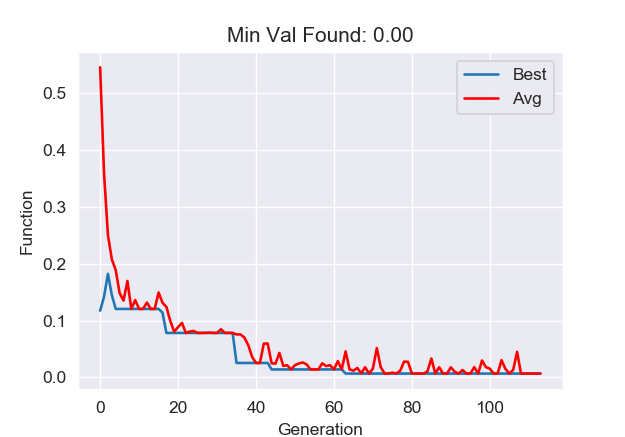

The smallest value of f found is 0.00658 at x = -0.01847, y = 0.00352


In [30]:
def f(x):
    obj = 0.2 + sum(x[i]**2 - 0.1*np.cos(6*np.pi*x[i]) for i in range(len(x)))
    return obj 

def f_tuple(x):
    return (f(x),) # this version is for DEAP since it expects a tuple to be returned

low_bound = -1.0
high_bound = 1.0

individual_size = 2 # number of decision variables = dimension

# create a minimization problem
creator.create("NonConvex2D", base.Fitness, weights=(-1.0, ))
# tells us what kind of individuals we'll have - arrays of integers
creator.create("Individual",list,fitness=creator.NonConvex2D)

# configure toolbox
toolbox = base.Toolbox()

# define how we create an individual and a population
def create_individual(n):
    return np.random.uniform(low_bound,high_bound,size=n).tolist()

toolbox.register("indices",create_individual,individual_size)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness
toolbox.register("evaluate", f_tuple)
# Selection
toolbox.register("select", tools.selTournament, tournsize=3)
# Crossover
toolbox.register("mate", tools.cxOnePoint)
# Mutation
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=.3, indpb = .1)
# NEW - add decorator (a wrapper) to the mutation operator to clip to bounds
def checkBounds(min, max):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator
toolbox.decorate("mutate", checkBounds(low_bound, high_bound))

# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# define search parameters
pop_size = 20
crossover_prob = .8
mutation_prob = .2
max_gen = 200
max_no_improve = 50

# get solution
best_val, best_x, log = customGA(pop_size, crossover_prob, mutation_prob,
                                     max_gen, max_no_improve)

# plot search convergence
fig = plt.figure(figsize=(5, 3.5))
line_best, = plt.plot(log.select('gen'), log.select('min'), label='Best')
line_avg, = plt.plot(log.select('gen'),
                     log.select('avg'),
                     color='red',
                     label='Avg')

plt.xlabel('Generation')
plt.ylabel('Function')
plt.legend(handles=[line_best, line_avg])
plt.title('Min Val Found: {:.2f}'.format(int(best_val)))

print('The smallest value of f found is {:0.5f} at x = {:0.5f}, y = {:0.5f}'.format(best_val,best_x[0],best_x[1]))

Note that the use of the max_no_improve to stop the algorithm early may not work here since it's possible with continuous random variables to continue to make tiny improvements even though the genetic algorithm has roughly identified the optimum.  If we really want early stopping here, then we should monitor and stop when the changes become smaller than some threshold.

Since we're evolving a population of potential solutions (individuals) it's a bit harder to visualize.  Execute the next two cells in order to see a population of 200 evolve for this problem.

<IPython.core.display.Javascript object>


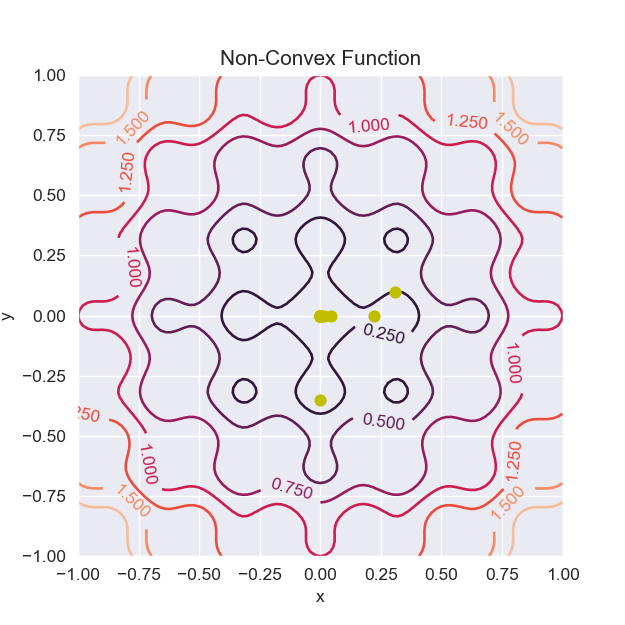

In [100]:
# execute this cell to initialize the plot and see the initial population
numx = 101
numy = 101
x = np.linspace(-1.0, 1.0, numx)
y = np.linspace(-1.0, 1.0, numy)
xx,yy=np.meshgrid(x,y)
z = np.zeros((numx,numy))
for i in range(numx):
    for j in range(numy):
        z[i,j] = f(np.array([xx[i,j],yy[i,j]]))

# Create a contour plot
fig = plt.figure()
fig.set_size_inches(5,5)
# Plot contours
contours = plt.contour(xx,yy,z)
# Label contours
plt.clabel(contours, inline=1, fontsize=10)
# Add some text to the plot
plt.title('Non-Convex Function')
plt.xlabel('x')
plt.ylabel('y');
fig.canvas.draw()
fig.show()

pop_size = 200
cx_prob = .8
mut_prob = .2
max_gen = 200
max_no_improve = 50


pop = toolbox.population(n=pop_size)
logbook = tools.Logbook()
hof = tools.HallOfFame(1)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

hof.update(pop)
best_val = hof[0].fitness.values
num_no_improve = 0
generation = 0

# initial plot of population
xpts = [p[0] for p in pop]
ypts = [p[1] for p in pop]
scatter, = plt.plot(xpts,ypts,'yo')

In [101]:
# execute this cell to see the population evolve
import time

while num_no_improve < max_no_improve and generation < max_gen:
    
    time.sleep(0.25)

    # Select the next generation individuals
    selected = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, selected))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cx_prob:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < mut_prob:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    num_evals = 0
    for ind, fit in zip(invalid_ind, fitnesses):
        num_evals += 1
        ind.fitness.values = fit

    # The population is entirely replaced by the offspring
    pop[:] = offspring
    xpts = [p[0] for p in pop]
    ypts = [p[1] for p in pop]
    scatter.set_xdata(xpts)
    scatter.set_ydata(ypts)
    fig.canvas.draw()
    fig.show()
    
    # track the best value and reset counter if there is a change
    hof.update(pop)
    curr_best_val = hof[0].fitness.values[0]
    num_no_improve += 1
    if curr_best_val != best_val:
        best_val = curr_best_val
        num_no_improve = 0

    # record stats
    record = stats.compile(pop)
    logbook.record(gen=generation, evals=num_evals, **record)

    # increment generation
    generation += 1

best_x = list(hof[0])

### <font color = "blue"> Self Assessment: Experiment with continuous GA </font>

We've recopied the code (not the local search version) into the code cell below.  Experiment a bit and try to answer some questions.

* Experiment with `tournsize` in line 23.  Tournament selection works by first choosing `tournsize` individuals from the population and then choosing the best of those to be selected.  Small values for `tournsize` allow more weaker (less optimal) individuals.  Large values make it hard for less optimal values to be selected.  How does `tournsize` affect convergence? What is happening is you make `tournsize` the same as the population size?
* Experiment with `indpb` at line 37.  This parameter is the probabilty that an element of an individual will undergo a mutation.  What happens if you increase it?
* Experiment with the scale parameter at line 37.  Large values mean larger moves.  How does this parameter affect convergence?
* What kind of search are you getting if you simply set crossover_prop = 0 and mut_prob = 1?  Is this effective?  What happens if you turn off mutation and only allow crossover?

In [ ]:
def f(x):
    obj = 0.2 + sum(x[i]**2 - 0.1*np.cos(6*np.pi*x[i]) for i in range(len(x)))
    return obj 

def f_tuple(x):
    return (f(x),) # this version is for DEAP since it expects a tuple to be returned

low_bound = -1.0
high_bound = 1.0

individual_size = 2 # number of decision variables = dimension

# create a minimization problem
creator.create("NonConvex2D", base.Fitness, weights=(-1.0, ))
# tells us what kind of individuals we'll have - arrays of integers
creator.create("Individual",list,fitness=creator.NonConvex2D)

# configure toolbox
toolbox = base.Toolbox()

# define how we create an individual and a population
def create_individual(n):
    return np.random.uniform(low_bound,high_bound,size=n).tolist()

toolbox.register("indices",create_individual,individual_size)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness
toolbox.register("evaluate", f_tuple)
# Selection
toolbox.register("select", tools.selTournament, tournsize=3)
# Crossover
toolbox.register("mate", tools.cxOnePoint)
# Mutation
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=.3, indpb = .1)
# NEW - add decorator (a wrapper) to the mutation operator to clip to bounds
def checkBounds(min, max):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator
toolbox.decorate("mutate", checkBounds(low_bound, high_bound))

# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# define search parameters
pop_size = 20
crossover_prob = .8
mutation_prob = .2
max_gen = 200
max_no_improve = 50

# get solution
best_val, best_x, log = customGA(pop_size, crossover_prob, mutation_prob,
                                     max_gen, max_no_improve)

# plot search convergence
fig = plt.figure(figsize=(5, 3.5))
line_best, = plt.plot(log.select('gen'), log.select('min'), label='Best')
line_avg, = plt.plot(log.select('gen'),
                     log.select('avg'),
                     color='red',
                     label='Avg')

plt.xlabel('Generation')
plt.ylabel('Function')
plt.legend(handles=[line_best, line_avg])
plt.title('Min Val Found: {:.2f}'.format(int(best_val)))

print('The smallest value of f found is {:0.5f} at x = {:0.5f}, y = {:0.5f}'.format(best_val,best_x[0],best_x[1]))

## GA for Continous with Local Search (video)

Notice that we're always getting close to the global optimum but not getting very many decimal places of accuracy.  Like simulated annealing, genetic algorithms can be good for exploring a large solution space but they're slow to converge once we are close to a good solution.

The genetic algorithm for continuous optimization could be improved by adding a local search as we did for the discrete TSP.  The next code block is a hacked proof of concept to show how this could work, but you'd have to change the fitness function at line 23 to make this work for other functions.  This code is slower because it does a local search to replace every individual in the population.  It should be possible to run for far fewer generations though.  In the homework you'll do this for the Rastrigin function.

In [103]:
# execute this cell for video
from IPython.display import IFrame
IFrame(
    "XXX_link_XXX",
    width=640,
    height=360)

In [92]:
# Hacked version of GA with local search
from scipy.optimize import minimize

def customGA_LS(pop_size, cx_prob, mut_prob, max_gen, max_no_improve):

    pop = toolbox.population(n=pop_size)
    logbook = tools.Logbook()
    hof = tools.HallOfFame(1)

    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    hof.update(pop)
    best_val = hof[0].fitness.values
    num_no_improve = 0
    generation = 0

    while num_no_improve < max_no_improve and generation < max_gen:
            
        for i in range(len(pop)):
            soln = minimize(f,pop[i],bounds=[(-1,1),(-1,1)],method='TNC') ### CHANGE HERE, replace f by your fitness function
            pop[i] = creator.Individual(list(soln.x))
            pop[i].fitness.values = (soln.fun,)            
            
        # Select the next generation individuals
        selected = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, selected))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_prob:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mut_prob:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        num_evals = 0
        for ind, fit in zip(invalid_ind, fitnesses):
            num_evals += 1
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # track the best value and reset counter if there is a change
        hof.update(pop)
        curr_best_val = hof[0].fitness.values[0]
        num_no_improve += 1
        if curr_best_val != best_val:
            best_val = curr_best_val
            num_no_improve = 0

        # record stats
        record = stats.compile(pop)
        logbook.record(gen=generation, evals=num_evals, **record)

        # increment generation
        generation += 1

    best_x = list(hof[0])

    return best_val, best_x, logbook

<IPython.core.display.Javascript object>


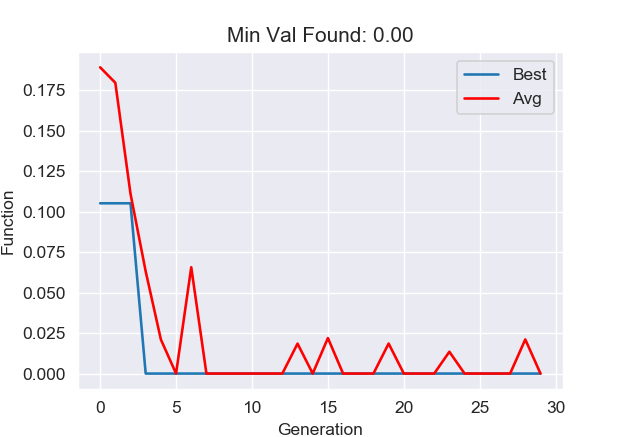

The smallest value of f found is 0.00000 at x = -0.00000, y = -0.00000


In [94]:
# define search parameters
pop_size = 10
crossover_prob = .8
mutation_prob = .2
max_gen = 30
max_no_improve = 30

# get solution
best_val, best_x, log = customGA_LS(pop_size, crossover_prob, mutation_prob,
                                     max_gen, max_no_improve)

# plot search convergence
fig = plt.figure(figsize=(5, 3.5))
line_best, = plt.plot(log.select('gen'), log.select('min'), label='Best')
line_avg, = plt.plot(log.select('gen'),
                     log.select('avg'),
                     color='red',
                     label='Avg')

plt.xlabel('Generation')
plt.ylabel('Function')
plt.legend(handles=[line_best, line_avg])
plt.title('Min Val Found: {:.2f}'.format(int(best_val)))

print('The smallest value of f found is {:0.5f} at x = {:0.5f}, y = {:0.5f}'.format(best_val,best_x[0],best_x[1]))

Convergence is almost immediate and it converges to the correct optimumum to within the tolerance of the lcoal search.